<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Electric-Power-Consumption-in-[GWh/a]" data-toc-modified-id="Electric-Power-Consumption-in-[GWh/a]-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Electric Power Consumption in [GWh/a]</a></span></li><li><span><a href="#Gas-consumption-in-[MWh/a]" data-toc-modified-id="Gas-consumption-in-[MWh/a]-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gas consumption in [MWh/a]</a></span></li></ul></div>

# Show the disaggregator overview

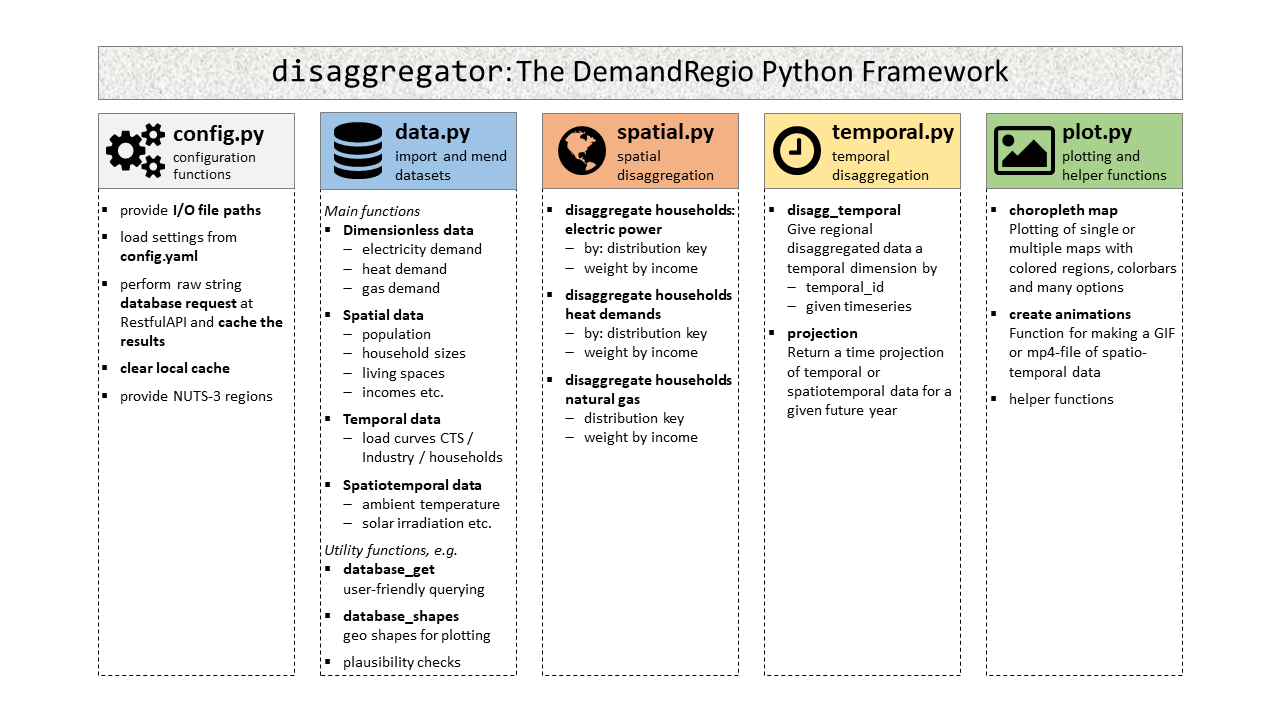

In [1]:
from IPython.display import Image

pic = Image(filename=("./img/overview.png"))
pic

# Spatial disaggregation with `spatial.py`

Now, as we've gathered a spatial feeling for the relevant input data in the first notebook, let's take a look at the spatial disaggregation abilities.

In [2]:
import pandas as pd
from disaggregator import spatial, plot

## Electric Power Consumption in [GWh/a]

The disaggregation method for the electric power consumption of private households is `spatial.disagg_households_power()` and requires at least one argument:

1. ``by`` is the distribution key and must be one of ``['population', 'households']``.  

    Using ``population`` invokes a *top-down*-method, i.e. the overall electricity consumption of entire Germany is being spread by distribution keys based on the population to calculate the consumption per region.  
    Using ``households`` invokes a *bottom-up*-method, i.e. the average electricity consumptions known for each household size are used for calculating the consumption per region.

Additionally, an income adjustment can be performed, through the switch ``weight_by_income=True``.

Let's start with ``population``:

In [3]:
ec_pop = spatial.disagg_households_power(by="population", weight_by_income=False)
ec_pop.head()

2025-09-25 14:08:20 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 14:08:20 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 14:08:20 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 14:08:20 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of t

nuts3
DE111    1001.919449
DE112     612.457232
DE113     841.912846
DE114     405.994406
DE115     857.890857
Name: value, dtype: float64

... and continue with ``households``:

In [4]:
# NOTE: The values below seem much higher than on the original notebook. On the original the year is 2000, here it is 2011.
ec_hh = spatial.disagg_households_power(by="households", weight_by_income=False)
ec_hh.head()

2025-09-25 14:08:24 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 14:08:24 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.


2025-09-25 14:08:24 disaggregator.data: INFO     Merging old Göttingen+Osterode to new NUTS-v2016 region.


hh_size         1         2         3         4         5   6
nuts3                                                        
DE111    739.1364  529.2906  428.1053  155.5870  194.4384 NaN
DE112    402.1116  214.5340  270.4485  110.9920  157.0920 NaN
DE113    572.6301  313.4758  395.8192  148.1545  205.7016 NaN
DE114    272.6067  146.9718  185.7499   73.3340  102.5544 NaN
DE115    565.9431  302.2688  381.1437  156.0825  219.9288 NaN

So, do these two fundamentally different methods lead to comparable results? Let's check, by summing the consumptions of all six household types per region:

In [5]:
ec_hh.head().sum(axis=1)

nuts3
DE111    2046.5577
DE112    1155.1781
DE113    1635.7812
DE114     781.2168
DE115    1625.3669
dtype: float64

Okay, that seems comparable.  
Let's further check the results by plotting these side by side on *one* map. We can achieve this, by merging the results into one new ``pd.DataFrame`` :

In [6]:
ec_combined = pd.concat(
    [ec_pop, ec_hh.sum(axis=1)], keys=["population", "households"], axis=1, join="inner"
)
ec_combined.head()

population  households
nuts3                         
DE111  1001.919449   2046.5577
DE112   612.457232   1155.1781
DE113   841.912846   1635.7812
DE114   405.994406    781.2168
DE115   857.890857   1625.3669

... and plot:

2025-09-25 13:51:15 disaggregator.plot: WARNING  Indices not common to both dataframes: {'DE91C', 'DE80L', 'DE80M', 'DE80O', 'DE80K', 'DE915', 'DE80J', 'DE919', 'DE80N'}
2025-09-25 13:51:15 disaggregator.plot: WARNING  Indices in df but NOT in shapefile: {'DE91C'}
2025-09-25 13:51:15 disaggregator.plot: WARNING  Indices in df but NOT in shapefile: {'DE91C'}


Using NUTS 2013 data for base year 2015
Using existing NUTS shapefile.
data/NUTS_RG_01M_2013_4326_LEVL_3.shp
Loaded shapefile with 1480 features
Filtered to 402 German NUTS regions
Set NUTS_ID as index


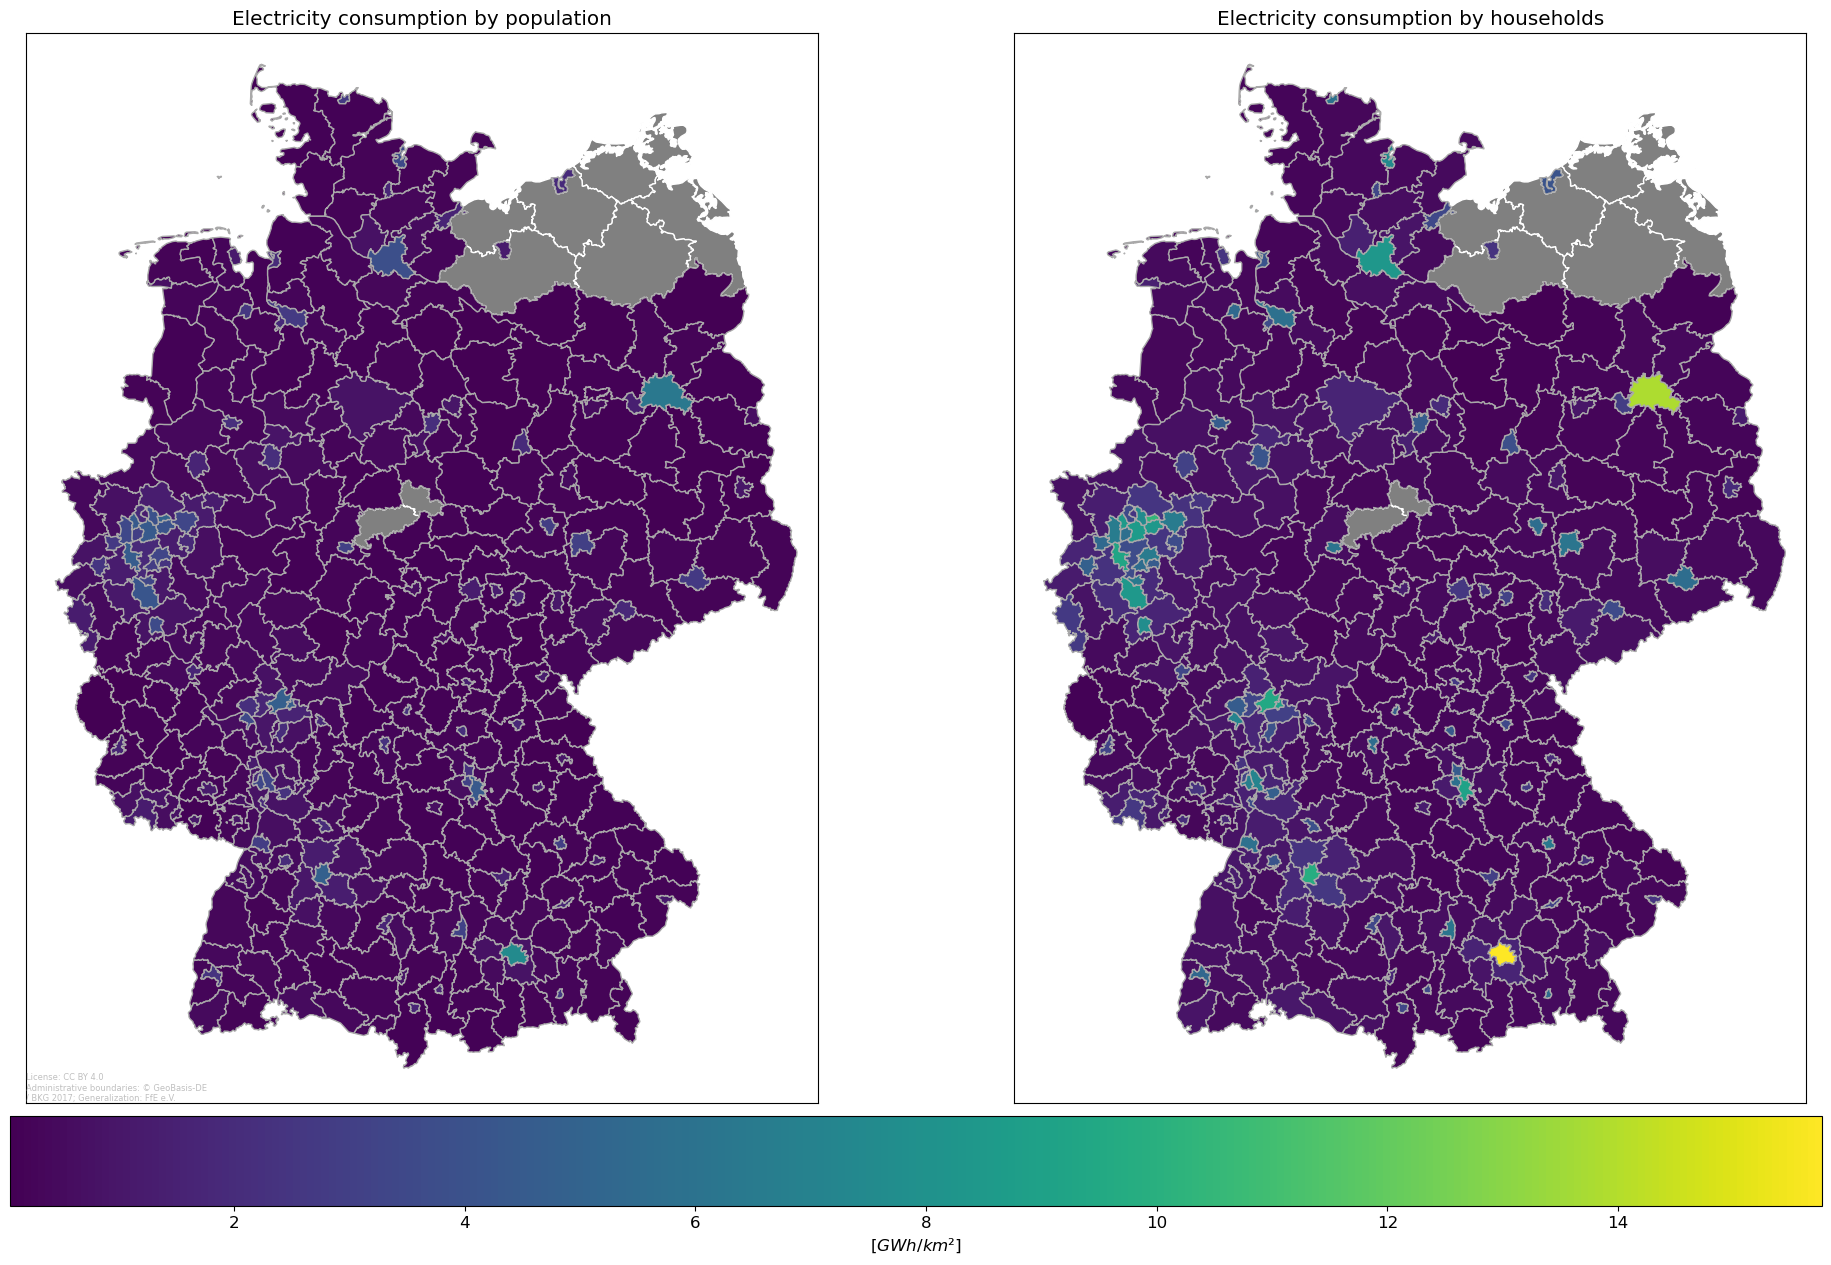

In [7]:
fig, ax = plot.choropleth_map(
    ec_combined,
    relative=True,
    unit="GWh",
    axtitle="Electricity consumption by",
    add_percentages=False,
    shape_source_api=False,
)

Now let's weight the consumptions by the available income:

In [8]:
ec_pop_ic = spatial.disagg_households_power(by="population", weight_by_income=True)
ec_hh_ic = spatial.disagg_households_power(by="households", weight_by_income=True)
ec_combined = pd.concat(
    [ec_pop, ec_hh.sum(axis=1), ec_pop_ic, ec_hh_ic.sum(axis=1)],
    keys=["population", "households", "population (weighted)", "households (weighted)"],
    axis=1,
    join="inner",
)

2025-09-25 13:51:16 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:16 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:16 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:16 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of t

2025-09-25 13:51:16 disaggregator.data: INFO     Merging old Göttingen+Osterode to new NUTS-v2016 region.


2025-09-25 13:51:16 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:16 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:16 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:16 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of t

2025-09-25 13:51:16 disaggregator.plot: WARNING  Indices not common to both dataframes: {'DE91C', 'DE80L', 'DE80M', 'DE80O', 'DE80K', 'DE915', 'DE80J', 'DE919', 'DE80N'}
2025-09-25 13:51:16 disaggregator.plot: WARNING  Indices in df but NOT in shapefile: {'DE91C'}
2025-09-25 13:51:16 disaggregator.plot: WARNING  Indices in df but NOT in shapefile: {'DE91C'}


Using NUTS 2013 data for base year 2015
Using existing NUTS shapefile.
data/NUTS_RG_01M_2013_4326_LEVL_3.shp
Loaded shapefile with 1480 features
Filtered to 402 German NUTS regions
Set NUTS_ID as index


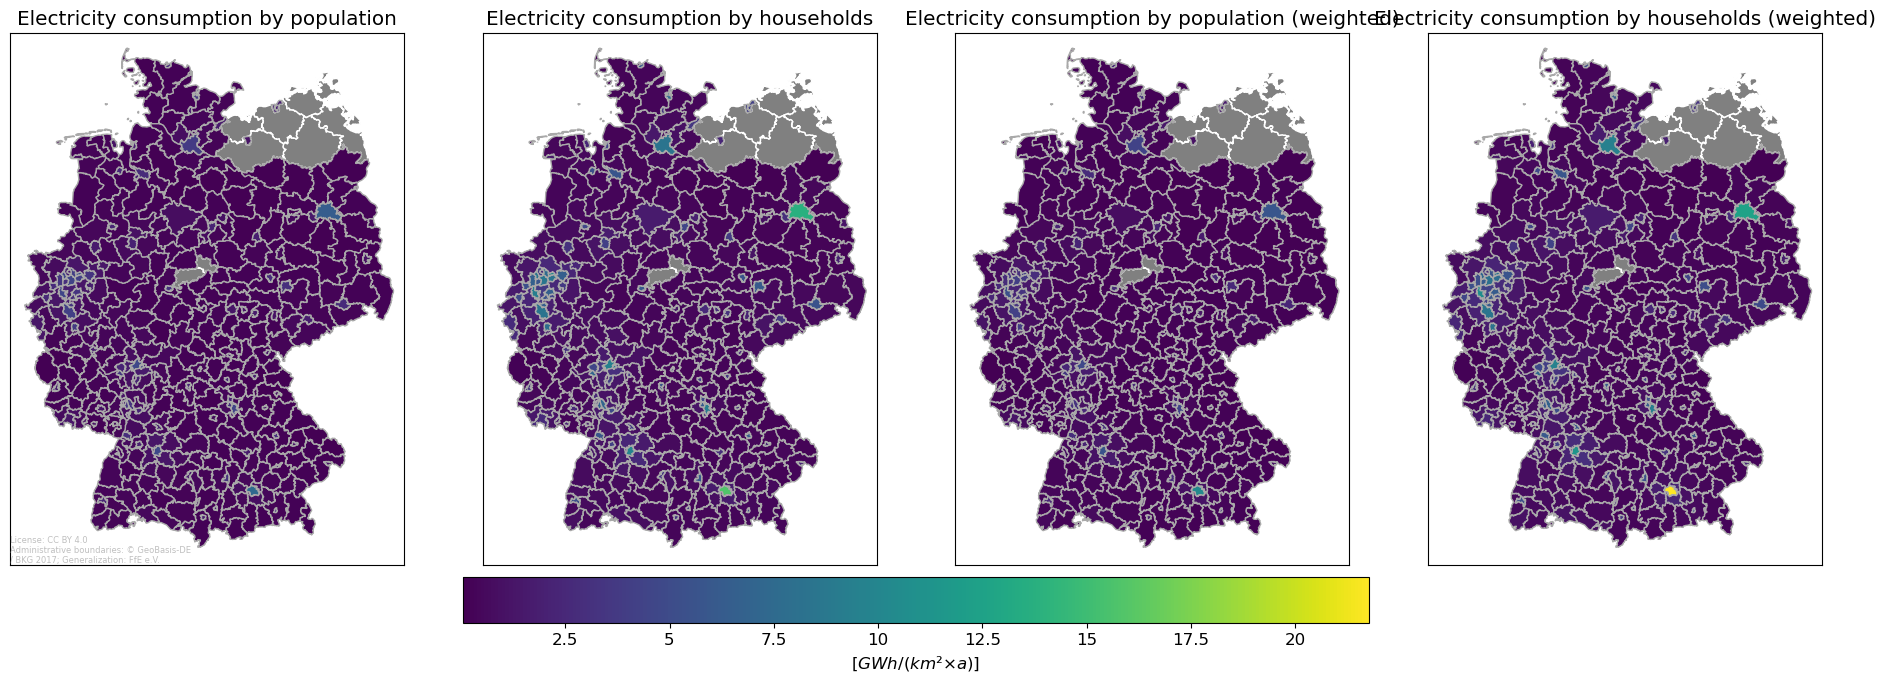

In [9]:
fig, ax = plot.choropleth_map(
    ec_combined,
    relative=True,
    unit="GWh/a",
    axtitle="Electricity consumption by",
    add_percentages=False,
    figsize=(20, 12),
    nrows=1,
    ncols=4,
    shape_source_api=False,
)

Now save this figure e.g. as PDF file:

In [10]:
from disaggregator.config import data_out

fig.savefig(data_out("disagg_households_power.pdf"), bbox_inches="tight")

## Gas consumption in [MWh/a]

The gas demands of private households are threefold:
1. cooking (=process heat)
2. warm water
3. space heating

The first two ones depend mainly on the **household size**, whereas the latter depends mainly on the **size of the building**. However, centralized space heating systems are very often also used as boilers for the hot water supply.

In [11]:
df_gas_td = spatial.disagg_households_gas(how="top-down")
df_gas_td.head()

2025-09-25 13:51:21 disaggregator.data: INFO     Using living space data for year 2018.


2025-09-25 13:51:24 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:25 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.


2025-09-25 13:51:25 disaggregator.data: INFO     Merging old Göttingen+Osterode to new NUTS-v2016 region.


2025-09-25 13:51:25 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:25 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:25 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:25 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of t

2025-09-25 13:51:25 disaggregator.data: INFO     Merging old Göttingen+Osterode to new NUTS-v2016 region.
2025-09-25 13:51:25 disaggregator.spatial: INFO     Calculating regional gas demands top-down.


Cooking       HotWater  SpaceHeating
nuts3                                          
DE111  8699.403066  337979.140588  9.619266e+05
DE112  4732.727120  206601.208685  7.007097e+05
DE113  6739.676259  284003.849403  9.600965e+05
DE114  3208.495160  136954.762744  5.137948e+05
DE115  6660.972371  289393.738285  1.033030e+06

In [12]:
df_gas_bu = spatial.disagg_households_gas(how="bottom-up")
df_gas_bu.head()

2025-09-25 13:51:25 disaggregator.data: INFO     Using living space data for year 2018.


2025-09-25 13:51:29 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:30 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.


2025-09-25 13:51:30 disaggregator.data: INFO     Merging old Göttingen+Osterode to new NUTS-v2016 region.


2025-09-25 13:51:30 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:30 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:30 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:30 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of t

2025-09-25 13:51:30 disaggregator.data: INFO     Merging old Göttingen+Osterode to new NUTS-v2016 region.
2025-09-25 13:51:30 disaggregator.spatial: INFO     Calculating regional gas demands bottom-up.
2025-09-25 13:51:30 disaggregator.data: INFO     Using living space data for year 2018.


2025-09-25 13:51:34 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.


2025-09-25 13:51:34 disaggregator.data: INFO     Requesting data from https://api.opendata.ffe.de/demandregio/demandregio_spatial?id_spatial=56&year=2018 (attempt 1/6)


2025-09-25 13:51:41 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.
2025-09-25 13:51:41 disaggregator.config: WARNING  The mapping of the AGS to NUTS-3 regions is done using the file t_nuts3_lk.csv which is for a unknown year. This may not correspond entirely to the AGS number of the data fetched for another year from opendata.


Cooking       HotWater   SpaceHeating
nuts3                                           
DE111  8699.403066  337979.140588  848858.277006
DE112  4732.727120  206601.208685  715476.269692
DE113  6739.676259  284003.849403  931479.321340
DE114  3208.495160  136954.762744  501044.405876
DE115  6660.972371  289393.738285  963624.305592

2025-09-25 13:51:41 disaggregator.plot: WARNING  Indices not common to both dataframes: {'DE91C', 'DE915', 'DE919'}
2025-09-25 13:51:41 disaggregator.plot: WARNING  Indices in df but NOT in shapefile: {'DE91C'}
2025-09-25 13:51:41 disaggregator.plot: WARNING  Indices in df but NOT in shapefile: {'DE91C'}


Using NUTS 2013 data for base year 2015
Using existing NUTS shapefile.
data/NUTS_RG_01M_2013_4326_LEVL_3.shp
Loaded shapefile with 1480 features
Filtered to 402 German NUTS regions
Set NUTS_ID as index


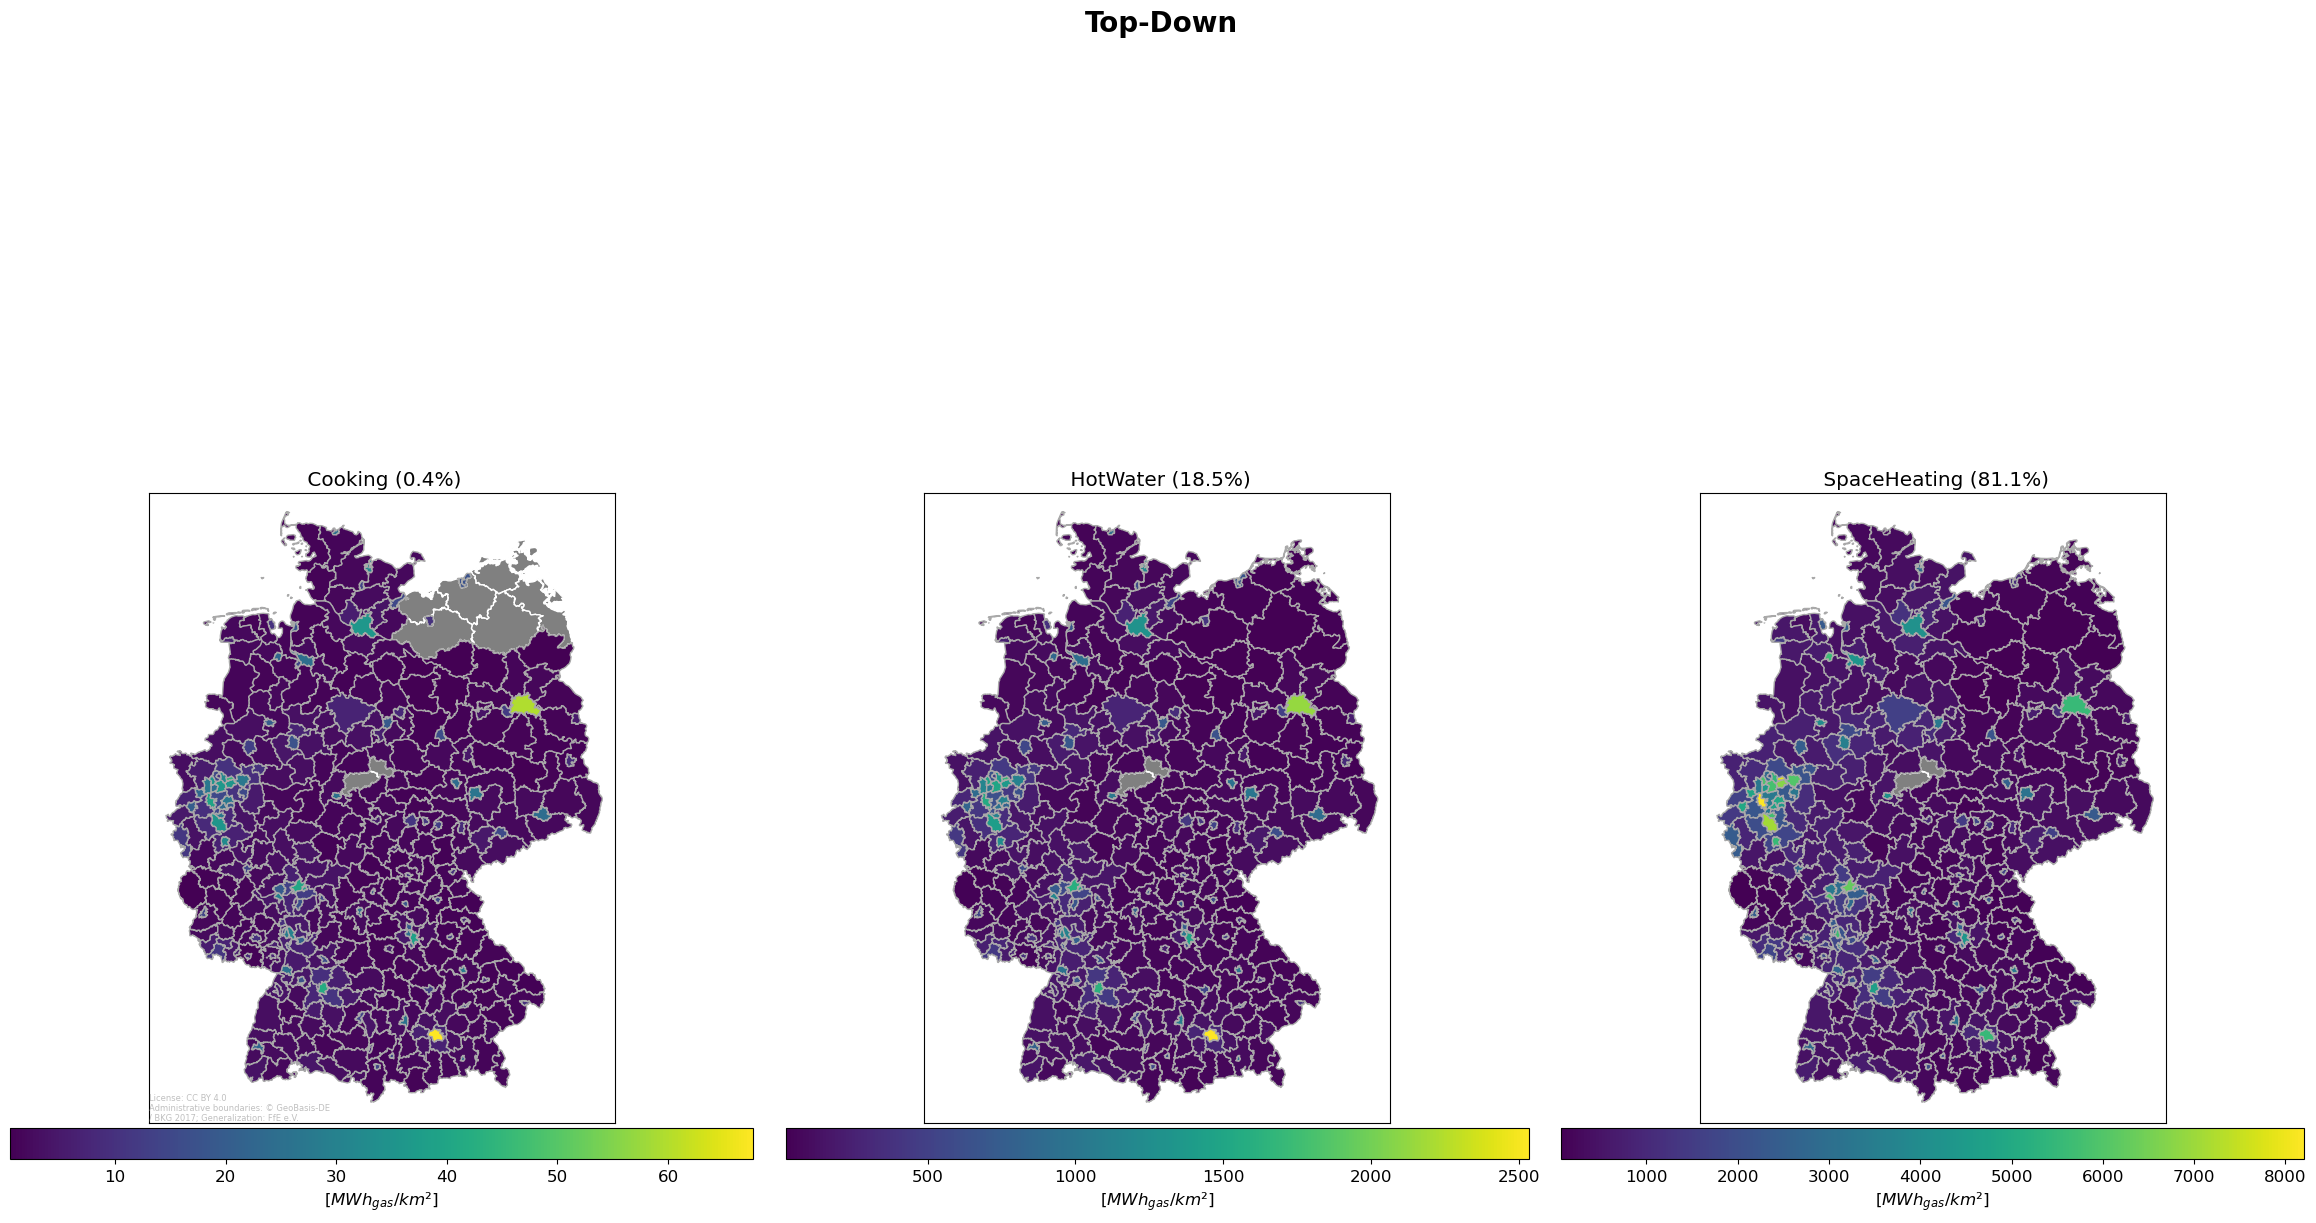

In [13]:
fig, ax = plot.choropleth_map(
    df_gas_td,
    unit="MWh_{gas}",
    colorbar_each_subplot=True,
    add_percentages=True,
    suptitle="Top-Down",
    shape_source_api=False,
)

2025-09-25 13:51:43 disaggregator.plot: WARNING  Indices not common to both dataframes: {'DE91C'}
2025-09-25 13:51:43 disaggregator.plot: WARNING  Indices in df but NOT in shapefile: {'DE91C'}
2025-09-25 13:51:43 disaggregator.plot: WARNING  Indices in df but NOT in shapefile: {'DE91C'}


Using NUTS 2013 data for base year 2015
Using existing NUTS shapefile.
data/NUTS_RG_01M_2013_4326_LEVL_3.shp
Loaded shapefile with 1480 features
Filtered to 402 German NUTS regions
Set NUTS_ID as index


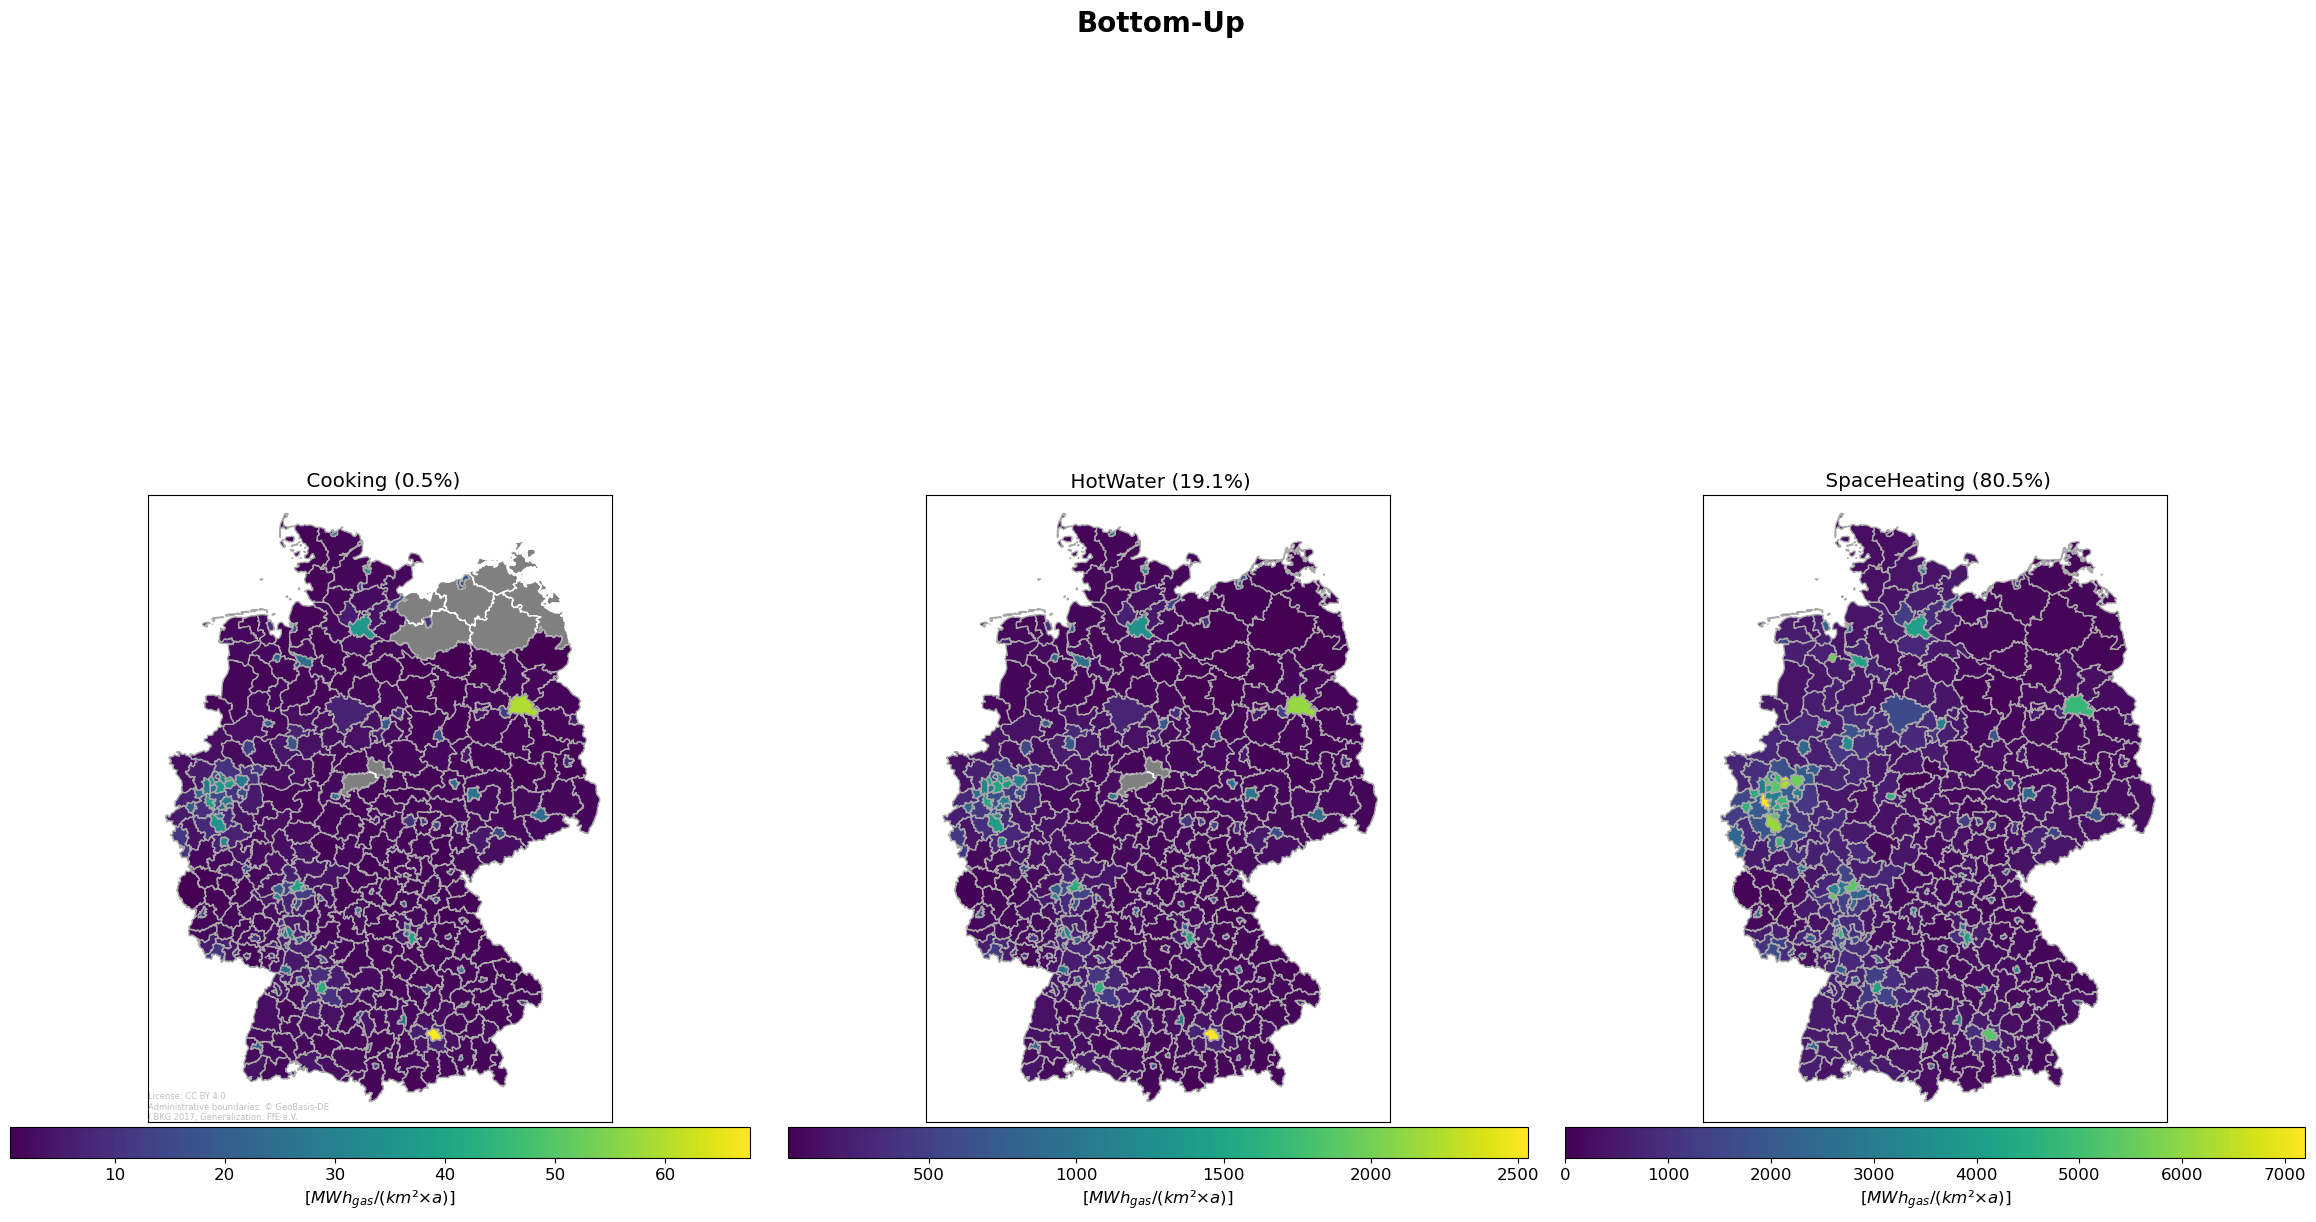

In [14]:
fig, ax = plot.choropleth_map(
    df_gas_bu,
    unit="MWh_{gas}/a",
    colorbar_each_subplot=True,
    add_percentages=True,
    suptitle="Bottom-Up",
    shape_source_api=False,
)